### RWSE-Checker: true-positives statistics from balanced corpus

In [24]:
from cassis import Cas, load_typesystem

from rwse import RWSE_Checker
from util.helper import collect_sentences_by_confusion_sets, normalize_report, replace_confusion_set_words_in_sentences

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy

In [25]:
T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


#### Load sentences by confusion sets

In [26]:
file_name = 'input/eng_news_2023-balanced-sentences.csv'

with open(file_name, 'r') as f:
    sentences = f.readlines()

sentences_cleaned = [sentence.split('\t')[1].strip() for sentence in sentences]

sentences_by_confusion_sets = collect_sentences_by_confusion_sets(rwse.confusion_sets.values(), sentences_cleaned,nlp)

total = 0

for key, value in sorted(sentences_by_confusion_sets.items()):
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Being,begin,being = 213
Capital,Capitol,capital = 111
Country,County,country,county = 168
Desert,desert,dessert = 101
Easy,ease,easy = 111
Effect,affect,effect = 118
Effects,affects,effects = 105
Except,accept,except = 105
Few,View,few,view = 168
Form,From,form,from = 643
Found,Fund,found,fund = 160
Fourth,forth,fourth = 117
Hole,Whole,hole,whole = 110
Lead,Led,lead,led = 146
Life,Live,life,live = 172
Mad,Made,mad,made = 169
Or,or,ore = 325
Past,passed,past = 127
Peace,Piece,peace,piece = 109
Plain,plain,plane = 104
Principal,principal,principle = 102
Provence,Province,province = 101
Quiet,Quite,quiet,quite = 110
Rise,raise,rise = 105
Safe,Save,safe,save = 120
Site,sight,site = 116
Split,spit,split = 101
Than,Then,than,then = 276
Their,There,They,their,there,they = 654
Them,Theme,them,theme = 178
Things,things,thinks = 115
Three,Tree,three,tree = 166
To,Too,Two,to,too,two = 2463
Trail,Trial,trail,trial = 109
Weather,Whether,weather,whether = 119
Week,weak,week = 151
Were,Where,were,whe

#### Switch confusion words in sentences

In [27]:
file_name = 'output/falsified_eng_new_2023-balanced-sentences.pkl'

if not os.path.exists(file_name):
    modified_sentences_by_confusion_sets = replace_confusion_set_words_in_sentences(sentences_by_confusion_sets, nlp)
    with open(file_name, 'wb') as f:
        pickle.dump(modified_sentences_by_confusion_sets, f)
else:
    modified_sentences_by_confusion_sets = pickle.load(open(file_name, 'rb'))


total = 0
for key, value in modified_sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 140
advice,advise = 105
Effect,affect,effect = 157
Being,begin,being = 261
bitch,pitch = 108
brakes,breaks = 103
Capital,Capitol,capital = 146
Site,sight,site = 158
Country,County,country,county = 352
crab,crap = 102
Desert,desert,dessert = 137
Easy,ease,easy = 149
Effects,affects,effects = 144
extend,extent = 102
feat,feet = 116
Few,View,few,view = 344
Form,From,form,from = 1414
Fourth,forth,fourth = 154
forms,forums = 102
Found,Fund,found,fund = 338
Lead,Led,lead,led = 298
Life,Live,life,live = 370
loose,lose = 104
Mad,Made,mad,made = 346
Or,or,ore = 390
Past,passed,past = 164
Peace,Piece,peace,piece = 228
Plain,plain,plane = 143
Principal,principal,principle = 137
Provence,Province,province = 116
Quiet,Quite,quiet,quite = 220
Rise,raise,rise = 145
Safe,Save,safe,save = 250
Split,spit,split = 139
Than,Then,than,then = 572
Their,There,They,their,there,they = 3092
Them,Theme,them,theme = 378
Things,things,thinks = 159
Trail,Trial,trail,trial = 228
Three,Tree,thre

#### Determine RWSEs

In [28]:
file_name = 'output/report_true_positives_balanced.csv'

result = dict()

if not os.path.exists(file_name):
    false_negatives = []
    header = ['confusion_set', 'expected', 'target', 'masked_sentence']
    file_false_negatives = open('output/false_negatives_balanced.csv', 'w')
    print(*header, sep='\t', file=file_false_negatives)
    file_missed_positives =  open('output/missed_positives_balanced.csv', 'w')
    print(*header, sep='\t', file=file_missed_positives)
    for confusion_set, box in modified_sentences_by_confusion_sets.items():
        rwse.set_confusion_sets([set(confusion_set.split(','))])
        matches = 0
        for item in box:
            cas = Cas(ts)
            sentence = item['sentence']
            # TODO clean sentence?
            cas.sofa_string = sentence
            doc = nlp(cas.sofa_string)
            cas_sentence = S(begin=0, end=len(sentence))
            cas.add(cas_sentence)
            for token in doc:
                cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                cas.add(cas_token)
            rwse.check_cas(cas, ts)
            true_positives = cas.select(T_RWSE)
            masked_sentence = sentence[:item['new_token']['begin']] + '[MASK]' + sentence[item['new_token']['end']:]
            if len(true_positives) == 0:
                print(confusion_set, item['org_word'], item['new_token']['word'], masked_sentence, sep='\t', file=file_false_negatives)
            elif len(true_positives) == 1 and true_positives[0].suggestion == item['org_word']:
                    matches += 1
            else:
                print(confusion_set, item['org_word'], item['new_token']['word'], masked_sentence, sep='\t', file=file_missed_positives)
        result[confusion_set] = {
            'num_sentences':len(box),
            'num_matches':matches,
        }
    file_missed_positives.close()
    file_false_negatives.close()

    with open(file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key, value in result.items():
            print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
else:
    with open(file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            print(confusion_set, num_matches, num_sentences, sep='\t', end='\n')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}

#### Determine Sensitivity (True-Positive-Rate)

In [29]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'true positive rate: {total_matches/total:.2f}')
print(f'correctly identified {total_matches} out of {total}')

true positive rate: 0.95
correctly identified 29895 out of 31317


<Axes: xlabel='confusion_set'>

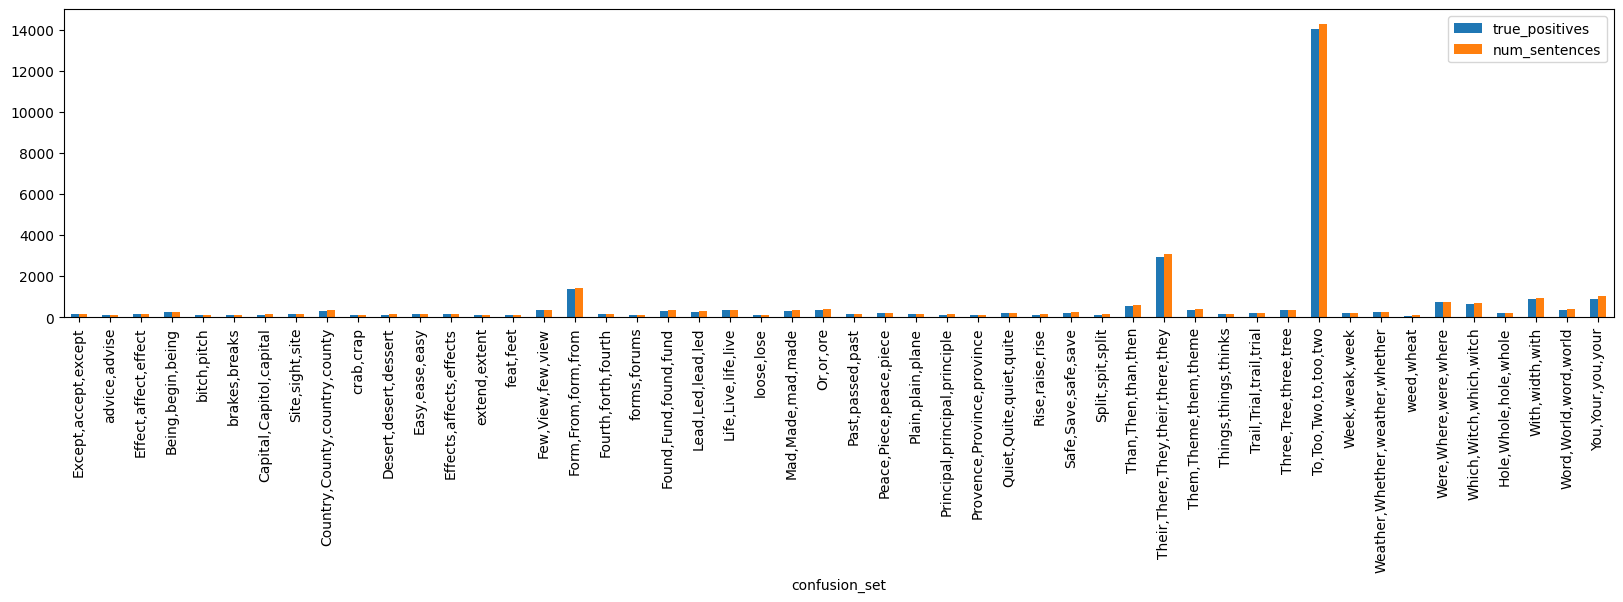

In [30]:
tp_df = pd.read_csv(file_name, sep=';')
tp_df.columns = ['confusion_set', 'true_positives', 'num_sentences']
tp_df.index = tp_df['confusion_set']
tp_df.plot(kind="bar", figsize=(20,4))

#### Determine Mean Sensitivity

In [31]:
file_name = 'output/report_true_positives_balanced.csv'

data_mean_sensitivity = normalize_report(file_name)

mean_sensitivity = sum(data_mean_sensitivity.values())/ len(data_mean_sensitivity)

print(f'Mean Sensitivity = {mean_sensitivity:.10f}')

Mean Sensitivity = 0.9172687263


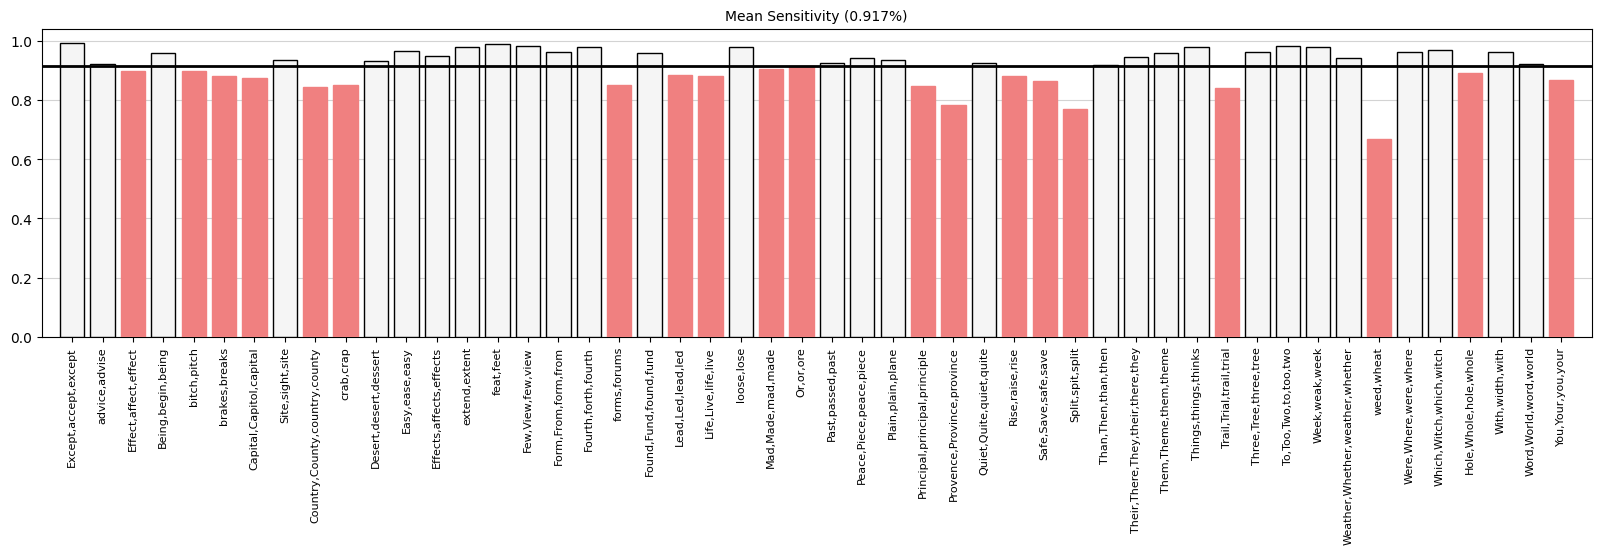

In [32]:
xticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.3f}%)", fontsize=10)
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
#ax.plot(xticks,[mean_sensitivity]*len(xticks), zorder=3, color="black", linewidth=1)
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(x=0) # removes white space surrounding bars

x = np.linspace(-1, len(data_mean_sensitivity))
y = [mean_sensitivity]*len(x)
ax.plot(x, y, zorder=3, color="black", linewidth=2)

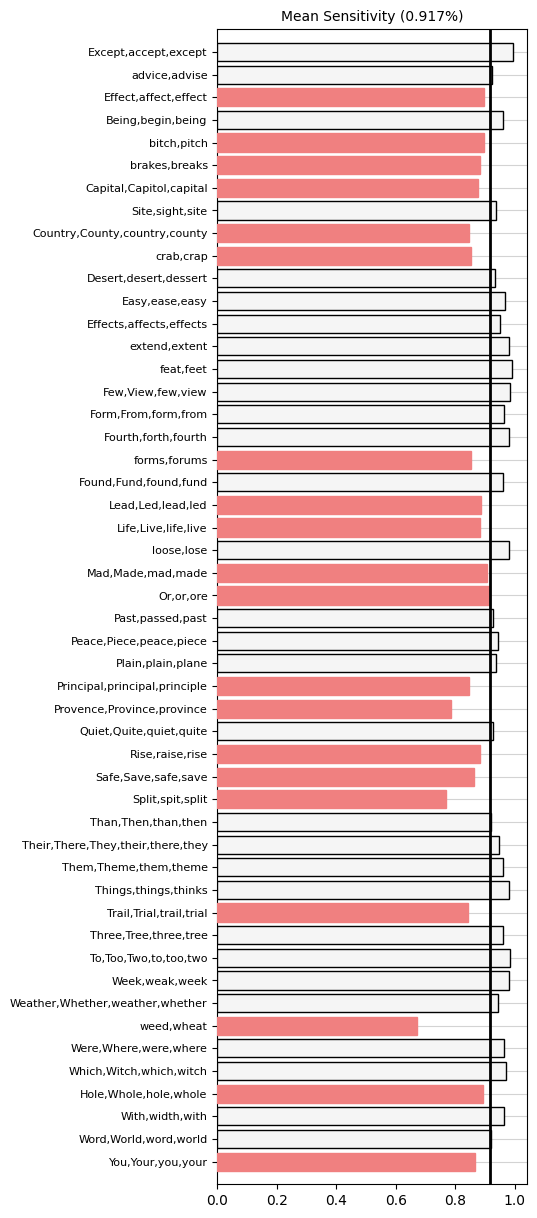

In [33]:
yticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

values.reverse()
labels.reverse()

fig, ax = plt.subplots(figsize=(4,15))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.3f}%)", fontsize=10)
bars = ax.barh(yticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
ax.set_yticks(yticks, labels, rotation='horizontal')
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(y=0)

x = [mean_sensitivity]*len(x)
y = np.linspace(-1, len(data_mean_sensitivity))
ax.plot(x, y, zorder=3, color="black", linewidth=2)